# Lyncs, a Python API for Lattice QCD applications

Installation: `conda/pip install lyncs`

Documentation: [lyncs.readthedocs.io](https://lyncs.readthedocs.io/en/latest/ "https://lyncs.readthedocs.io/en/latest/")

Available at [github.com/sbacchio/lyncs](https://github.com/sbacchio/lyncs "https://github.com/sbacchio/lyncs")

## Objectives

* **API:** interface to many LQCD libraries within a common framework.

* **User-friendly:** a particular attention is dedicated to the high-level interface.

* **Flexible:** the same calculation can be performed in a number of ways. 

* **Tunable:** many computational options are free parameters that will be set at run-time.

* **Modular-computing:** multiple tasks can be performed at the same time fully exploiting the cluster allocation.

* **Crosschecks:** Automatic crosschecks between different implementations.

* **Benchmarks:** Automatic benchmarks of different implementations.

## Status: Done
* **Design:** decisions on the structure of the API and implementation details

* **Dependencies:** investigated the most suitable tools for Lyncs

  * **[Dask](https://dask.org/ "https://dask.org/"):** 
  a flexible library for parallel computing in Python.
    * Distributed tasks management
    * Tasks graph optimization
    * Distributed array tools
    
  * **[cppyy](https://cppyy.readthedocs.io/ "https://cppyy.readthedocs.io/"):** 
  automatic Python-C++ bindings
  
  * _**[Tune](https://ray.readthedocs.io/en/latest/tune.html "https://ray.readthedocs.io/en/latest/tune.html"):**_ 
  scalable Hyperparameter Tuning
  
* **First-routines:** important routines of the API have been implemented to test feasibility

* **Compilation:** external libraries are automatically downloaded, patched and compiled.

## Status: Planned

* **Core:** the main core of the API should be completed in the next month

* **Support:** interface to DDalphaAMG, tmLQCD, QUDA, PLEGMA

* **Installation:** simple installation via pip/conda

* **Go public:** first release with documentation (**milestone**: end of April)

* **Tests on DEEP-EST:** granted access to the DEEP-EST cluster (March-November)

# Introduction to Lyncs

The two main structures of the Lyncs API are 

* The **lattice** encoding all the information about the lattice structure.

* The **field** for managing data-structures that live on the lattice.

## Lattice object

The lattice field theory is represented by the `lyncs.Lattice` object.

* Defines the names of the dimensions and degree-of-freedom of the lattice.

* Defines the properties of the lattice (e.g. boundary conditions, structure, etc...).

* Every field is defined on the same lattice.

### Example

In [1]:
import lyncs as ly
lattice = ly.Lattice(dims=4, dofs="QCD")
lattice

Lattice(dims = {'t': 1, 'x': 1, 'y': 1, 'z': 1},
        dofs = {'spin': 4, 'color': 3},
        dtype = dtype('complex128'),
        properties = {'time': ['t'], 'space': ['x', 'y', 'z'], 'gauge_dofs': ['color']})

We have created a four dimensional lattice with dimensions (x,y,z,t) and with the degree of freedom of QCD, i.e. color and spin.

The lattice dimensions and properties can be edited in a simple and flexible manner.

In [2]:
lattice.t = 8
lattice['x'] = 4
lattice.space = 4
lattice.dims

{'t': 8, 'x': 4, 'y': 4, 'z': 4}

## Field object

On the lattice we define fields and they are represented by the `lyncs.Field` object.

* A field lives on a set of dimensions and degree-of-freedom  of the lattice.

* Basic field types are implemented, e.g. scalar, vector, etc. 

* Custom fields can be defined from a list of properties of the lattice.

### Example

On the previous lattice we define a field, e.g. a vector type.

**NOTE:** the shape order is not significant.

In [3]:
field = ly.Field(lattice=lattice, field_type="vector")
field.shape

[('t', 8), ('x', 4), ('y', 4), ('z', 4), ('spin', 4), ('color', 3)]

**NOTE:** the field has not been allocated and the field content is a Delayed object.

In [4]:
field.field

Delayed('zero_field-5560b0a596f212b135ac03f13b038a59')

### Tunable options

The field is well defined but has been created only in a lazy manner and will not be allocated or computed until we explicitly ask to evaluate its content.

In such way we can postpone decisions on the structure and distribution of the field accordingly to the calculations that will be performed in order to optimize the time to solution.

**NOTE:** the field has several tunable options which value will be decided at run-time

In [5]:
field.tunable_options

{'shape_order': Permutation(['t', 'x', 'y', 'z', 'spin', 'color']),
 'chunks': ChunksOf({'t': 8, 'x': 4, 'y': 4, 'z': 4})}

### Computational graph

The list of computations is represented by a graph that can be easily visualized and optimized.

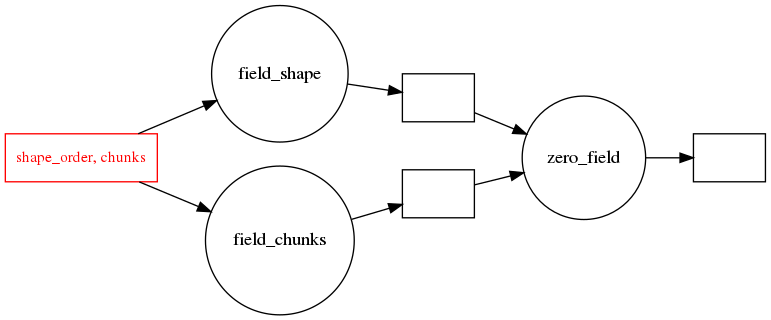

In [6]:
field.visualize(rankdir="LR")

### Tuning options

A not tuned property of the field is a delayed attribute.

In [7]:
field.shape_order

Delayed('getattr-05e0dbd6155adfbb21f27645a3517183')

When the value of a tunable option is set or tuned, this becomes a tuned option and cannot be changed anymore.

In [8]:
field.shape_order.tune()
field.chunks = {'t':2, 'x':2, 'y':2}
field.tuned_options

{'shape_order': ['t', 'x', 'y', 'z', 'spin', 'color'],
 'chunks': {'t': 2, 'x': 2, 'y': 2}}

### Resolution of the graph

Now that all the tunable options have been computed, the field is well defined.

In [9]:
field.field

,Array,Chunk
Bytes,98.30 kB,6.14 kB
Shape,"(8, 4, 4, 4, 4, 3)","(2, 2, 2, 4, 4, 3)"
Count,16 Tasks,16 Chunks
Type,complex128,numpy.ndarray


# Lyncs high-level framework

In lyncs we try as much as possible to deduce at runtime information about the run providing a very user-friendly framework.

## Example

Loading a gauge-configuration from a stored file does not require any information about the lattice or the file format (e.g. 'lime' in the following case) and these will be automatically deduced at runtime.

In [10]:
import lyncs as ly
conf_path = "conf.1000"
gauge_conf = ly.load(conf_path)
gauge_conf

Field(field = Delayed('read_field-c5b98449aa691aafca686f24c5b7f8e6'),
      lattice = Lattice(dims = {'t': 4, 'x': 4, 'y': 4, 'z': 4},
                        dofs = {'spin': 4, 'color': 3},
                        dtype = dtype('complex128'),
                        properties = {'time': ['t'], 'space': ['x', 'y', 'z'], 'gauge_dofs': ['color']}),
      field_type = 'gauge_links',
      coords = {},
      labels = {'t': {'n_dims': 0}, 'x': {'n_dims': 3}, 'y': {'n_dims': 2}, 'z': {'n_dims': 1}},
      tunable_options = {'chunks': ChunksOf({'t': 4, 'x': 4, 'y': 4, 'z': 4})},
      tuned_options = {'dirs_order': ['t', 'z', 'y', 'x'], 'shape_order': ['t', 'z', 'y', 'x', 'n_dims', 'color', 'color'], 'color_order': 'row_major'})

**NOTE:** the tuned options are due to the data format.

### Delayed reading

**NOTE:** again the field has been created lazily postponing the reading of the data content in a next step (\`Delayed('read_array-...')\`).

In [11]:
gauge_conf.field

Delayed('read_field-c5b98449aa691aafca686f24c5b7f8e6')

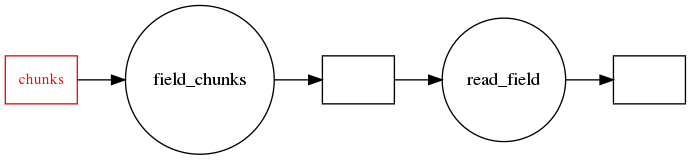

In [12]:
gauge_conf.visualize(rankdir="LR")

### After fixing the chunks

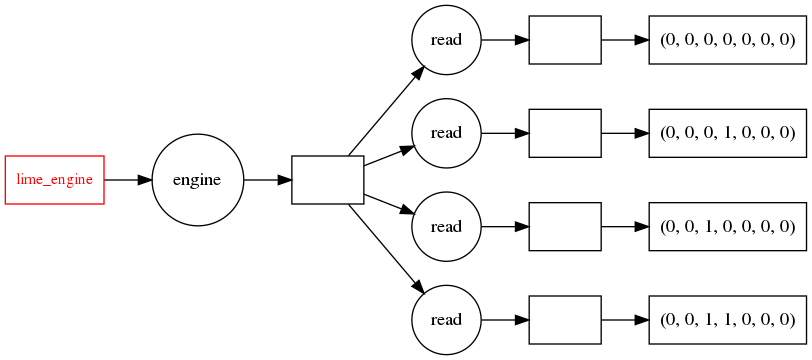

In [13]:
gauge_conf.chunks = {'x': 2, 'y': 2}
gauge_conf.visualize(rankdir="LR")

In [14]:
ly.zeros_like(gauge_conf, field_type="vector")

Field(field = Delayed('zero_field-d338cf9cc42e6abd3b2f84f2fd76d5e9'),
      lattice = Lattice(dims = {'t': 4, 'x': 4, 'y': 4, 'z': 4},
                        dofs = {'spin': 4, 'color': 3},
                        dtype = dtype('complex128'),
                        properties = {'time': ['t'], 'space': ['x', 'y', 'z'], 'gauge_dofs': ['color']}),
      field_type = 'vector',
      coords = {},
      labels = {},
      tunable_options = {'shape_order': Permutation(['t', 'x', 'y', 'z', 'spin', 'color']), 'chunks': ChunksOf({'t': 4, 'x': 4, 'y': 4, 'z': 4})},
      tuned_options = {})

In [15]:
gauge_conf.plaquette

<function lyncs.fields.gauge_links.plaquette(self, dirs=None)>